In [1]:
import torch
import numpy as np

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN



from classical import (
    ClassicalMLP,
    train_classical,
    inference_classical,
    plot_pca_decision_boundary_classical,
    plot_3d_decision_boundary_classical
)
from quantum import (
    QuantumMLP,
    train_quantum,
    inference_quantum_simulator,
    plot_pca_decision_boundary_quantum_simulator,
    plot_3d_decision_boundary_quantum
)

In [ ]:
# --- Data Prep ---
# minist = load_digits()
# X = minist.data
# y = minist.target
X, y = make_moons(n_samples=800, noise=0.1, random_state=42)
target_names = [1,2]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

torch.Size([560, 2]) torch.Size([560])
torch.Size([560, 2]) torch.Size([560])
torch.Size([560, 2]) torch.Size([560])
torch.Size([560, 2]) torch.Size([560])
torch.Size([560, 2]) torch.Size([560])
Epoch 5/10 | Loss: 0.3673
torch.Size([560, 2]) torch.Size([560])
torch.Size([560, 2]) torch.Size([560])
torch.Size([560, 2]) torch.Size([560])
torch.Size([560, 2]) torch.Size([560])
torch.Size([560, 2]) torch.Size([560])
Epoch 10/10 | Loss: 0.2575
torch.Size([240])
------------------------------
       Classical MODEL RESULTS       
------------------------------
Accuracy:           90.42%
Training Time:      0.66025 sec
Inference Time:      0.00015 sec
------------------------------


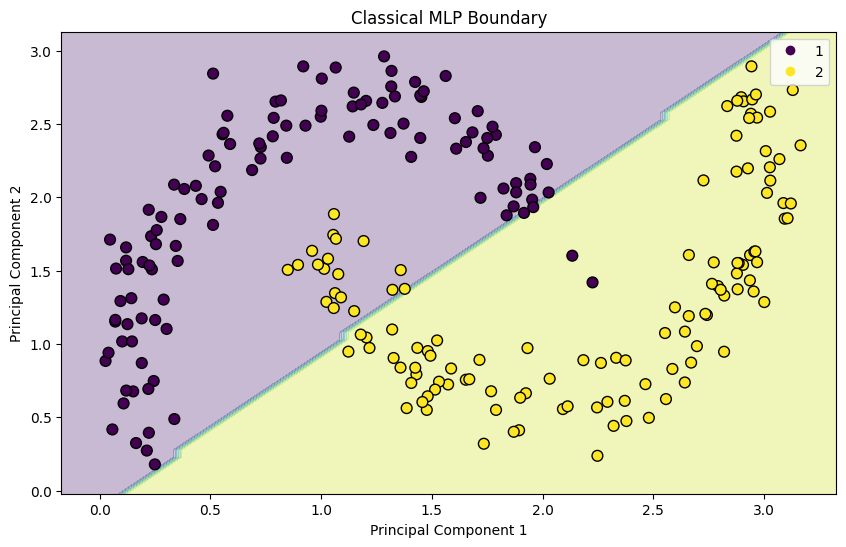

In [3]:
classical_model = ClassicalMLP(output_dim=len(target_names))

trained_model, training_time = train_classical(
    classical_model, 10, X_train_tensor, y_train_tensor
)
accuracy, inference_time, _ = inference_classical(
    trained_model, X_test_tensor, y_test_tensor
)

print(y_test_tensor.shape)

print("-" * 30)
print("       Classical MODEL RESULTS       ")
print("-" * 30)
print(f"Accuracy:           {accuracy * 100:.2f}%")
print(f"Training Time:      {training_time:.5f} sec")
print(f"Inference Time:      {inference_time:.5f} sec")
print("-" * 30)

# Use the tensors from your successful run
plot_pca_decision_boundary_classical(trained_model, X_test_tensor, y_test_tensor, target_names)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Setting up Simulator...
Training for 50 epochs...
Epoch 2/50 | Loss: 0.7216
Epoch 4/50 | Loss: 0.7020
Epoch 6/50 | Loss: 0.6715
Epoch 8/50 | Loss: 0.6333
Epoch 10/50 | Loss: 0.6003
Epoch 12/50 | Loss: 0.5522
Epoch 14/50 | Loss: 0.5110
Epoch 16/50 | Loss: 0.4886
Epoch 18/50 | Loss: 0.4517
Epoch 20/50 | Loss: 0.3963
Epoch 22/50 | Loss: 0.3740
Epoch 24/50 | Loss: 0.3799
Epoch 26/50 | Loss: 0.3680
Epoch 28/50 | Loss: 0.3663
Epoch 30/50 | Loss: 0.3489
Epoch 32/50 | Loss: 0.3478
Epoch 34/50 | Loss: 0.3403
Epoch 36/50 | Loss: 0.3304
Epoch 38/50 | Loss: 0.3320
Epoch 40/50 | Loss: 0.3275
Epoch 42/50 | Loss: 0.3210
Epoch 44/50 | Loss: 0.3198
Epoch 46/50 | Loss: 0.3148
Epoch 48/50 | Loss: 0.3096
Epoch 50/50 | Loss: 0.3100
------------------------------
       Quantum Simulator MODEL RESULTS       
------------------------------
Accuracy:           81.25%
Training Time:      810.99107 sec
Inference Time:     0.38488 sec
------------------------------
Plot saved.


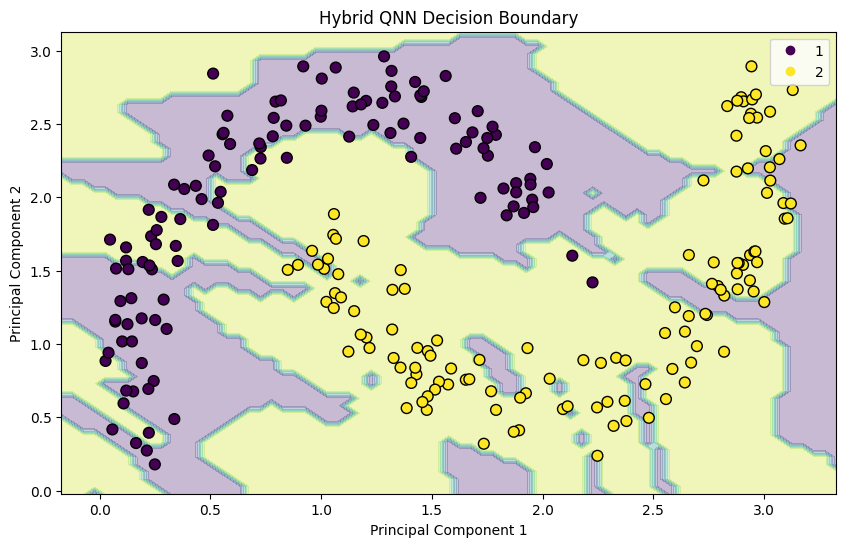

In [4]:
# Circuit Setup
num_qubits = 2
# feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
# ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2, entanglement="circular")

feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear')
ansatz = EfficientSU2(num_qubits=2, reps=2, entanglement='full')

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

observables = [
    SparsePauliOp.from_list([("IZ", 1)]),
    SparsePauliOp.from_list([("ZI", 1)]),
]

# Simulator Run
print("Setting up Simulator...")
estimator = StatevectorEstimator()
qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    observables=observables,
    estimator=estimator,
)

quantum_model = QuantumMLP(qnn, output_dim=len(target_names))

# Train
trained_model_q, training_time_q = train_quantum(
    quantum_model, 50, X_train_tensor, y_train_tensor
)

accuracy_qs, inference_time_qs, predictions_qs = inference_quantum_simulator(
    trained_model_q, X_test_tensor, y_test_tensor
)

print("-" * 30)
print("       Quantum Simulator MODEL RESULTS       ")
print("-" * 30)
print(f"Accuracy:           {accuracy_qs * 100:.2f}%")
print(f"Training Time:      {training_time_q:.5f} sec")
print(f"Inference Time:     {inference_time_qs:.5f} sec")
print("-" * 30)

plot_pca_decision_boundary_quantum_simulator(
    trained_model_q, X_test_tensor, y_test_tensor, target_names
)

3D Plot saved as 'classical_3d_decision_boundary.png'


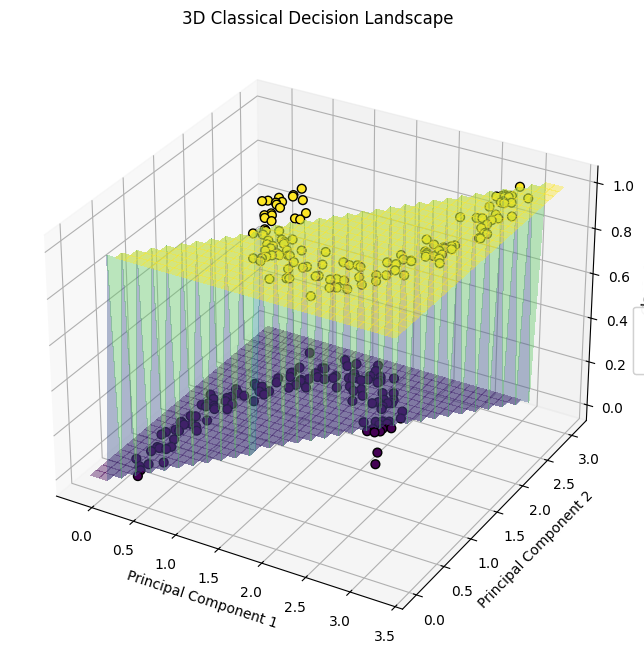

In [7]:
plot_3d_decision_boundary_classical(trained_model, X_test_tensor, y_test_tensor, target_names)


3D Plot saved as 'quantum_3d_decision_boundary.png'


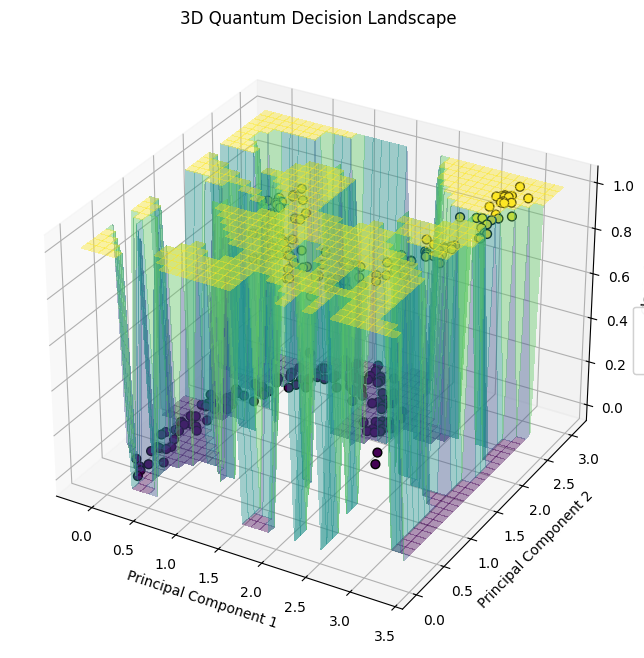

In [8]:
plot_3d_decision_boundary_quantum(trained_model_q, X_test_tensor, y_test_tensor, target_names)
